## HW 3 - Modeling NBA Twitter Activity
### Guy Dotan - 02/13/2019

### Importing packages & loading directory

In [110]:
'''
     File name: hw3_prelim_model.py
     Author: Guy Dotan
     Date: 02/13/2019
     Course: UCLA Stats 404
     Description: HW #3. Preliminary model to predict NBA twitter followers from on their basketball stats.
'''

from collections import Counter
import inspect
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, \
                            mean_squared_error, roc_auc_score
import os
from IPython.display import display

# file diretory
notebook_dir = os.getcwd()
notebook_dir

# file path
path = 'social-power-nba/'
df = pd.read_csv(path + "nba_2017_players_with_salary_wiki_twitter.csv")

### Quick EDA for our outcome variable: Twitter Retweets (in millions)

In [111]:
df.head()
df.isna().any()

# remove columns with NULL value for outcome variable
fulldata = df[np.isfinite(df['TWITTER_RETWEET_COUNT'])]

# calculate a 5-number summary
data = fulldata['TWITTER_RETWEET_COUNT']
quartiles = np.percentile(data, [25, 50, 75])
data_min, data_max = data.min(), data.max()

# print 5-number summary
print('Min: %.3f' % data_min)
print('Q1: %.3f' % quartiles[0])
print('Median: %.3f' % quartiles[1])
print('Q3: %.3f' % quartiles[2])
print('Max: %.3f' % data_max)

Min: 0.000
Q1: 8.000
Median: 15.000
Q3: 47.875
Max: 2941.000


### Bucket Data

In [122]:
# Group outcome variable into five buckets
# ignore warning messing, taken from...
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None # None|'warn'|'raise'

tweetlabels = ["<10", "10-50", "50-150", "150+"]

bin_cut = pd.cut(fulldata['TWITTER_RETWEET_COUNT'],
                       bins = [-np.inf, 10, 50, 150, np.inf],
                       labels = tweetlabels ) 

print(bin_cut.value_counts())

fulldata['TWEET_CAT'] = bin_cut

<10       90
10-50     87
50-150    34
150+      25
Name: TWITTER_RETWEET_COUNT, dtype: int64


,PLAYER,TWITTER_RETWEET_COUNT,TWEET_CAT
25,Joel Embiid,2941.0,150+
7,Stephen Curry,2893.0,150+
35,Derrick Rose,2504.5,150+
5,LeBron James,1501.5,150+
6,Kawhi Leonard,716.5,150+


### Highest five players

In [125]:
nba = pd.DataFrame(fulldata)
nba = nba.sort_values(['TWITTER_RETWEET_COUNT', 'PLAYER'], ascending=[True, True])

nba[['PLAYER','TWITTER_RETWEET_COUNT', 'TWEET_CAT']].head()

,PLAYER,TWITTER_RETWEET_COUNT,TWEET_CAT
84,Terrence Ross,0.0,<10
90,Courtney Lee,1.0,<10
67,Dwight Howard,1.0,<10
140,Garrett Temple,1.0,<10
180,Malcolm Delaney,1.0,<10


### Lowest five players

In [124]:
nba[['PLAYER','TWITTER_RETWEET_COUNT', 'TWEET_CAT']].head()

,PLAYER,TWITTER_RETWEET_COUNT,TWEET_CAT
25,Joel Embiid,2941.0,150+
7,Stephen Curry,2893.0,150+
35,Derrick Rose,2504.5,150+
5,LeBron James,1501.5,150+
6,Kawhi Leonard,716.5,150+


### Split data into train and test set

In [92]:
df_train, df_valid = train_test_split(nba,
                                      test_size=0.25,
                                      random_state=2019,
                                      stratify=nba['TWEET_CAT'])

df_train['TWEET_CAT'].value_counts(sort=True)
df_valid['TWEET_CAT'].value_counts(sort=True)

y = df_train['TWEET_CAT']
X = df_train[['AGE','WINS_RPM','SALARY_MILLIONS','W', 'ORPM', 'DRPM','PIE']]

print(X.shape)
print(X.columns)

#X.isna().any()
#X[['3P%','FT%']] = X[['3P%','FT%']].fillna(0)

(177, 7)
Index(['AGE', 'WINS_RPM', 'SALARY_MILLIONS', 'W', 'ORPM', 'DRPM', 'PIE'], dtype='object')


### Build Random Forest model to estimate retweets

50
100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


250


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished


500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


1000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished


1500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    0.5s finished


2500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    1.0s finished


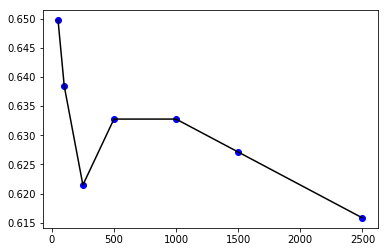

In [93]:
### --- Step 1: Specify different number of trees in forest, to determine
###             how many to use based on leveling-off of OOB error:
n_trees = [50, 100, 250, 500, 1000, 1500, 2500]

### --- Step 2: Create dictionary to save-off each estimated RF model:
rf_dict = dict.fromkeys(n_trees)

for num in n_trees:
    print(num)
    
    ### --- Step 3: Specify RF model to estimate:
    rf = RandomForestClassifier(n_estimators=num,
                                min_samples_leaf=30,
                                oob_score=True,
                                random_state=2019,
                                class_weight='balanced',
                                verbose=1)
    
    ### --- Step 4: Estimate RF model and save estimated model:
    rf.fit(X, y)
    rf_dict[num] = rf

# Compute OOB error per
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
oob_error_list = [None] * len(n_trees)

# Find OOB error for each forest size:
for i in range(len(n_trees)):
    oob_error_list[i] = 1 - rf_dict[n_trees[i]].oob_score_
else:
    # Visulaize result:
    plt.plot(n_trees, oob_error_list, 'bo',
             n_trees, oob_error_list, 'k')


### Assess model results

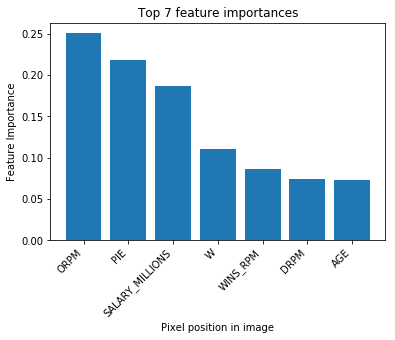

In [94]:
# Feature importance plot, modified from: 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
top_num = 7
forest = rf_dict[500]
importances = forest.feature_importances_

# Sort in decreasing order:
indices = np.argsort(importances)[::-1]
xvarlist = X.columns[indices]

# Plot the feature importances of the forest
ax = plt.gca()
plt.title(f"Top {top_num} feature importances")
plt.bar(range(top_num), importances[indices[0:top_num]])
plt.xticks(range(top_num))
ax.set_xticklabels(xvarlist, rotation = 45, ha='right')
ax.set_xlabel("Pixel position in image")
ax.set_ylabel("Feature Importance")
plt.show()


### Confusion matrix to check model rests

In [95]:
y_pred_train = forest.predict(X)
y_pred_train[0:5]

y_pred_train_probs = pd.DataFrame(forest.predict_proba(X))
y_pred_train_probs.head()


conf_mat = confusion_matrix(y_true=y,
                            y_pred=y_pred_train)

class_names = tweetlabels
conf_df = pd.DataFrame(conf_mat, class_names, class_names)
display(conf_df)

conf_df_pct = conf_df/conf_df.sum(axis=1)
display(round(conf_df_pct, 2))

preds = list(y_pred_train)
result_set = df_train

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


,<10,10-50,50-150,150+
<10,23,9,7,26
10-50,1,17,0,1
50-150,5,11,4,5
150+,9,7,4,48


,<10,10-50,50-150,150+
<10,0.35,0.47,0.28,0.38
10-50,0.02,0.89,0.00,0.01
50-150,0.08,0.58,0.16,0.07
150+,0.14,0.37,0.16,0.71


In [96]:
# Accuracy on train set
accuracy_score(y, y_pred_train)

0.519774011299435

### Validation set

In [97]:
y_valid = df_valid['TWEET_CAT']
X_valid = df_valid[['AGE','WINS_RPM','SALARY_MILLIONS','W', 'ORPM', 'DRPM','PIE']]

y_pred_valid = forest.predict(X_valid)

conf_mat_valid = confusion_matrix(y_true=y_valid,
                            y_pred=y_pred_valid)

display(conf_mat_valid)

accuracy_score(y_valid, y_pred_valid)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


array([[ 6,  5,  1, 10],
       [ 0,  4,  1,  1],
       [ 1,  6,  0,  2],
       [ 3,  5,  1, 13]])

0.3898305084745763

## Results and Intepretation


The goal of this model was to see if we could determine if we could predict an NBA's player social media presence based only on their on-the-court statistics. One would assume that the best players would be the ones with the highest social media following. But there could be other factors such as age, team, or market that have a greater impact.

In order to perform this model the first step was to transform the outcome variable "Twitter Retweet Count" into five buckets. We need to bucket these results because there is such a large spread and skewness in our dataset. The player with the most (Joel Embiid) had 2,941 million retweets while the player with the fewest (Terrence Ross) had 0 million. This could mean he has no Twitter followers or so much lower than 1 million that it got rounded to 0. Regardless the best way to conduct this model was to group into five buckets.

I decided to use a Random Forest model since that gave us the best opportunity to analyze the variables afterwards for some extra insights. A neural network for example would not allow us to examine the affect of the features. After running our Random Forest we saw that ORPM and PIE (two statistics that measure a players offensive impact) were the most significant features. Surprisngly, age was not too highly valued even if you might expect the younger players would be more active on Twitter.

In the end our model had decent results. As our confusion matrix shows, the model correctly predicted about 52% of the predictions from our training set. In the test or validation set, it predicted about 39%. Although this is far from perfect, it appears that our model is doing much better than a pure chance guess.

Further modeling approaches might examine some new variables (like market size) and some other techniques like some deep learning neural networks. 